# Shared Response Modeling
[Contributions](#contributions)

## Introduction
What is reliable across different participants when performing the same task, for example watching a movie? In previous notebooks, inter-subject correlation and inter-subject functional correlation revealed similarity in patterns of brain activity across participants. We can exploit this similarity to find a lower-dimensional shared space that retains features of the data that are common across participants. The shared response model (SRM) aims to learn this shared feature space and how to map individual participant data into it ([Chen et al., 2015](https://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model)). SRM can be used as a functional alignment technique: once fit, other data from the same participants can be transformed into the shared space with these mappings, to be used as input for other analyses.

In SRM, the brain data for each participant $i$ are represented as an $n$ voxel by $t$ time matrix $X_i$. A pre-specified number of features are used to learn a $k$ feature by $t$ time shared space $S$ and a participant-specific $n$ voxel by $k$ feature matrix $W_i$. This weight matrix, reflecting the loading of voxels onto features, is randomly initialized then fit over iterations to minimize the error in explaining participant data. At the same time, the time course of the features in the shared space is learned.

SRM can be summarized graphically as follows (from [Cohen et al., 2017](https://www.nature.com/articles/nn.4499)):![image](https://media.springernature.com/m685/nature-assets/neuro/journal/v20/n3/images/nn.4499-F4.jpg)

SRM requires that each participant be exposed to the same sequence of stimulus events. For this reason, continuous movies or stories are often used, although datasets (e.g., block-design localizers) where the trials are in the same order across participants have also been used with SRM. If counterbalancing was used between participants, it is technically possible to still perform SRM by rearranging the data, although mileage may vary. For best results, the epochs that are counterbalanced ought to be long (e.g., >30s). It is also important to note that SRM needs a lot of training data, up to 400 TRs or more for stable performance.

## Goal of this script
Use SRM to match a movie time segment. Specifically, be able to tell what part of Raiders of the Lost Ark the subject is viewing from their neural data.   
  


## Table of Contents
[1. Setup](#setup)  
>[1.1 Dataset description](#data_description)  
>[1.2 Example: Shared Lasagne Making](#SRM_logic)  
>[1.3 Splitting data into training and test](#split)

[2. SRM training](#srm_training)  
>[2.1 Similarity of timepoints](#srm_timepoints)  
>[2.2 The weight matrix](#srm_weights)  
>[2.3 ISC and SRM](#srm_alignment)

[3. SRM testing](#srm_testing)  
[4. Signal reconstruction](#srm_reconstruction)  
[5. Time-segment matching](#time_seg)  


In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 

import numpy as np
from scipy import stats
import scipy.spatial.distance as sp_distance
from sklearn.svm import NuSVC
import nibabel as nib

from brainiak.isc import isc
from brainiak.fcma.util import compute_correlation
import brainiak.funcalign.srm
from brainiak import image, io

import matplotlib.pyplot as plt

%autosave 5
%matplotlib inline

Autosaving every 5 seconds


## 1. Setup <a id="setup"></a>

### 1.1 Dataset description<a id="data_description"></a>

There are two datasets used in this notebook:

1. Raider dataset ([Haxby et al., 2011](https://doi.org/10.1016/j.neuron.2011.08.026)): We are using a pre-processed version of the data containing voxels from ventral temporal (VT) cortex in 10 subjects watching the movie, "Raiders of the Lost Ark". For these same participants and voxels, the dataset also includes eight runs where participants viewed images from seven categories. Each TR was 3s long and the movie was 2203 TRs long in total. Because the data have already been pre-processed and turned into a numpy file, we don't need to load them with nibabel tools.

2. Pieman dataset ([Simony et al., 2016](https://doi.org/10.1038/ncomms12141)): A full description of the dataset can be found in the ISC notebook. It includes 18 subjects who listened to a real-life story lasting seven minutes (intact condition). Subjects also listened to two scrambled versions of the story, generated by dividing the story into segments of different timescales (paragraphs and words, respectively) and then permuting the order of these segments.

First we will load in the data:

In [3]:
# Set up experiment metadata
from utils import raider_data_dir, results_path

print ('Dataset directory: %s' % raider_data_dir)

# Where do you want to store the results
dir_out = os.path.expanduser(results_path + '/srm_results')
if not os.path.exists(dir_out):
    os.makedirs(dir_out)
    print('Dir %s created ' % dir_out)

Dataset directory: /Users/aratzan/Downloads/brainiak_datasets/raider


In [4]:
# Load and inspect the shape of bold data

# Load data
movie_data = np.load(os.path.join(raider_data_dir, 'movie.npy'))

# Pull out the shape data
vox_num, nTR, num_subs = movie_data.shape  

print('Participants ', num_subs)
print('Voxels per participant ', vox_num)
print('TRs per participant ', nTR)

Participants  10
Voxels per participant  1000
TRs per participant  2203


### 1.3 Split data into training and test  <a id="split"></a>

We need to divide our data into training and test sets. The training data is used to train the model (i.e., to find the transformation from voxel space into feature space) and the test data is used for evaluating the model. 

In this case we are going to split each participant's movie viewing data down the middle, using the first half for training and the second half for testing. 

It is common when a dataset is continuous to use one half for training and the other half for testing in one fold, reverse the training and test sets in a second fold, and then average the results across both folds. 

In [5]:
train_data = []
test_data = []
for sub in range(num_subs):
    # Take the first half of TRs as training
    # *The double dash means integer division
    train_data.append(movie_data[:, :nTR//2, sub])
    
    # Take the second half of TRs as testing
    test_data.append(movie_data[:, -(nTR//2):, sub])  

Now normalize the data. This is done separately for training and testing data, to avoid peeking and double-dipping that could occur if the test data impacted the training normalization.

In [6]:
# Iterate through the subjects
for sub in range(num_subs):    
    
    # Do it for training data
    train_data[sub] = stats.zscore(train_data[sub], axis=1, ddof=1)
    train_data[sub] = np.nan_to_num(train_data[sub])
    
    # Do it for test data
    test_data[sub] = stats.zscore(test_data[sub], axis=1, ddof=1)
    test_data[sub] = np.nan_to_num(test_data[sub])

In [7]:
# Organization of data
# (10, 1000, 1101) each participant has 1000 voxels and 1101 TRs


## 2. SRM training <a id="srm_training"></a>

We are now ready to fit the data with SRM. First create an SRM object in BrainIAK with a specified number of features and iterations. Then fit this to our data.

Importantly, the SRM object has 'change-in-place' properties. This means that when you fit the data with this SRM object, that object is now changed to contain the results of fitting. To fit new data, you would need to create a new object.

Ideally, the number of features should be chosen using cross-validation. We will follow the lead of [Chen et al. (2015)](https://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model) for now and use 50 features. Typically, 20 iterations should be enough for SRM to converge.

In [8]:
features = 50  # many features to fit?
n_iter = 20  # iterations of fitting to perform

# Create the SRM object
srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=features)

# Fit the SRM data
print('Fitting SRM, may take a minute ...')
srm.fit(train_data)

print('SRM has been fit')

Fitting SRM, may take a minute ...
SRM has been fit


Let's zoom in and look at the first feature, i.e., the one that explains the most variance:

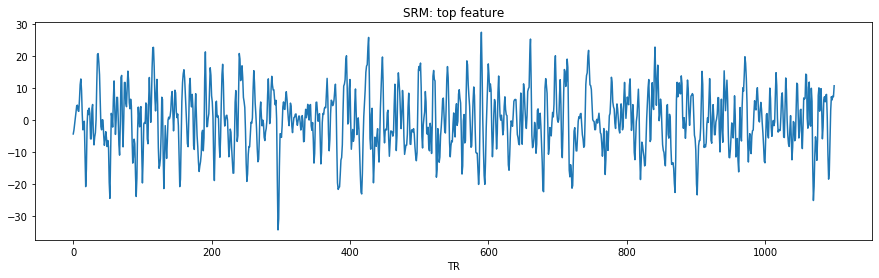

In [13]:
plt.figure(figsize=(15, 4))
plt.title('SRM: top feature')
plt.xlabel('TR')
plt.plot(srm.s_[0, :]);

**Explanation:**
By definition, this feature of brain activity is found consistently across participants. However, it is unclear where in the brain this feature is expressed. It is also unclear what stimulus information this feature represents. 

When there are spikes in the time course, such as around time point 300, something happened in the movie that is imporant to this feature. We could go back to the movie and examine what happened on screen at this time point, which would help better interpret the feature. For instance, we could go through the movie and code all of the times that Indiana Jones is in the scene and see if these spikes correspond to his presence. In reality, this feature is likely to code something much more abstract and complex than a specific person.

### 2.1 Similarity of timepoints <a id="srm_timepoints"></a>

We can now use this shared response to estimate how similar each timepoint is to one another. In other words, we treat each time point as a pattern of activity across the features and we correlate the pattern for each time point with the pattern for all other time points.  To do this, we calculate the distance between all time points in this $k$-dimensional space. Below, blue means that the time points are closer together or more similar. The yellow bands indicate time points where the patterns of activity diverge, potentially reflecting a unique time point in the movie.

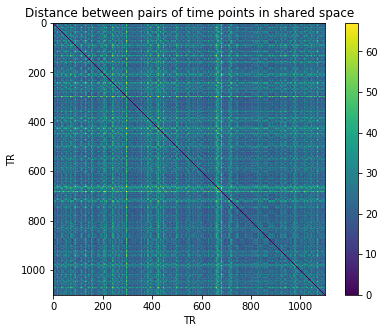

In [10]:
dist_mat = sp_distance.squareform(sp_distance.pdist(srm.s_.T))
plt.figure(figsize=(7,5))
plt.title('Distance between pairs of time points in shared space')
plt.xlabel('TR')
plt.ylabel('TR')
plt.imshow(dist_mat, cmap='viridis')
plt.colorbar()

### 2.2 The weight matrix <a id="srm_weights"></a>

In addition to the shared response matrix, we now also have an $n$ voxel by $k$ feature weight matrix for each participant that specifies how to map their data into the shared space. This is essentially a functional alignment transformation matrix. Below we visualize the weights associated with each feature for the same (anatomically-aligned) voxel in two different participants.

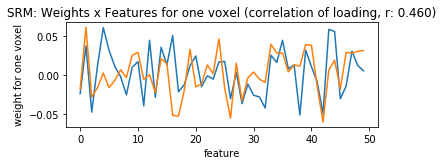

In [11]:
plt.subplot(211)

plt.plot(srm.w_[0][0,:])
plt.plot(srm.w_[1][0,:])
feature_corr = np.corrcoef(srm.w_[0][0,:], srm.w_[1][0,:].T)[0,1]
plt.title('SRM: Weights x Features for one voxel (correlation of loading, r: %0.3f)' % feature_corr) 
plt.xlabel('feature')
plt.ylabel('weight for one voxel')
plt.tight_layout()

Although there is some similarity, this shows that the same voxel loads on the features differently across participants. This means that anatomical alignment was not sufficient to align this function. Voxels that are more correlated with one another in terms of their raw time course are more likely to have similar loading into SRM space, regardless of anatomy.

### 2.3 ISC (Inter Subject Correlation) and SRM (Shared Response Modeling) <a id="srm_alignment"></a>

We can also transform (i.e., functionally align) individual participant data into the shared space. This produces a $k$ feature by $t$ time matrix for each participant based on what components of their brain activity are shared with other participants. The `srm.transform` method is used for this purpose.

In [12]:
# Transform the SRM data into shared space
shared_train = srm.transform(train_data)

# Zscore the transformed training data
for subject in range(num_subs):
    shared_train[subject] = stats.zscore(shared_train[subject], axis=1, ddof=1)

Insofar as SRM worked, these projected feature time courses should be more similar across participants than the original voxel activity. We can test this with ISC: even though the shared features aren't in brain space, we can still use them as input to the ISC function.

In [13]:
# Reorganize the data back into an appropriate space for ISC. Use np.transpose to make it TRs x Voxels x subj
raw_obj = np.zeros((train_data[0].shape[0], train_data[0].shape[1], len(train_data)))
for ppt in range(len(train_data)):
    raw_obj[:, :, ppt] = train_data[ppt]
raw_obj=np.transpose(raw_obj,[1,0,2]) 

# Perform ISC on all participants, collapsing across participants    
corr_raw = isc(raw_obj, summary_statistic='mean')
corr_raw = np.nan_to_num(corr_raw)  

# Reorganize the SRM transformed data back into an appropriate space for ISC
shared_obj = np.zeros((shared_train[0].shape[0], shared_train[0].shape[1], len(train_data)))
for ppt in range(len(train_data)):
    shared_obj[:, :, ppt] = shared_train[ppt]
shared_obj=np.transpose(shared_obj,[1,0,2]) # TRs x Voxels x Subjects for ISC.

# Perform ISC on all participants, collapsing across participants        
corr_shared = isc(shared_obj, summary_statistic='mean')
corr_shared = np.nan_to_num(corr_shared)

Independent samples t test between raw and SRM transformed data: 39.74711509137269 p: 2.0042237647345874e-211


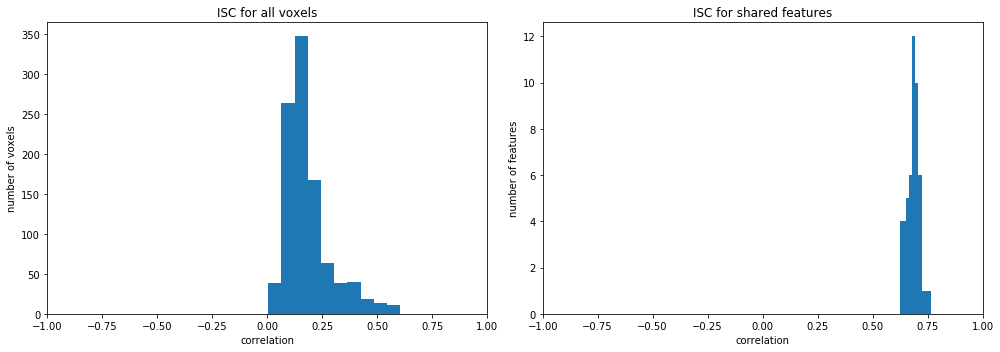

In [14]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.title('ISC for all voxels')
plt.hist(corr_raw);
plt.xlabel('correlation')
plt.ylabel('number of voxels')
plt.xlim([-1, 1]);

plt.subplot(1, 2, 2)
plt.title('ISC for shared features')
plt.hist(corr_shared);
plt.xlabel('correlation')
plt.ylabel('number of features')
plt.xlim([-1, 1]);

plt.tight_layout()

tstat = stats.ttest_ind(np.arctanh(corr_shared), np.arctanh(corr_raw))
print('Independent samples t test between raw and SRM transformed data:', tstat.statistic, 'p:', tstat.pvalue)

This analysis shows substantially greater similarity after SRM, but might be subject to double dipping. 

## 3. SRM testing <a id="srm_testing"></a>

We held out some data that were never seen by SRM, which we can use to evaluate performance. If the same participants completed other tasks (e.g., face vs. scene), we could similarly use the model to functionally align those data prior to analysis (e.g., classification). 

In [15]:
# Transform the test data into the shared space using the individual weight matrices
shared_test = srm.transform(test_data)

# Zscore the transformed test data
for subject in range(num_subs):
    shared_test[subject] = stats.zscore(shared_test[subject], axis=1, ddof=1)

Repeat  ISC analysis above on the test data, comparing ISC in the original voxel space vs. the shared feature space.

In [18]:
# Reorganize the SRM transformed data back into an appropriate space for ISC
shared_obj = np.zeros((shared_test[0].shape[0], shared_test[0].shape[1], len(test_data)))
for ppt in range(len(test_data)):
    shared_obj[:, :, ppt] = shared_test[ppt]
shared_obj=np.transpose(shared_obj,[1,0,2]) # TRs x Voxels x Subjects for ISC.

# Perform ISC on all participants, collapsing across participants        
corr_shared = isc(shared_obj, summary_statistic='mean')
corr_shared = np.nan_to_num(corr_shared)


Independent samples t test between raw and SRM transformed data: 25.321275214925162 p: 9.337095292954168e-111


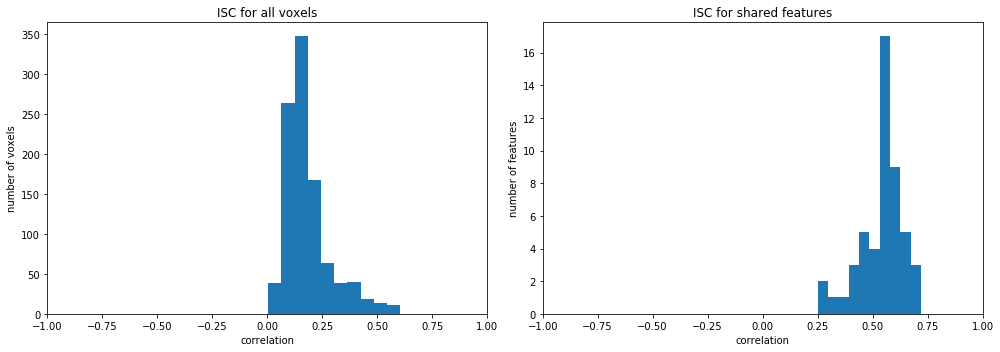

In [19]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.title('ISC for all voxels')
plt.hist(corr_raw);
plt.xlabel('correlation')
plt.ylabel('number of voxels')
plt.xlim([-1, 1]);

plt.subplot(1, 2, 2)
plt.title('ISC for shared features')
plt.hist(corr_shared);
plt.xlabel('correlation')
plt.ylabel('number of features')
plt.xlim([-1, 1]);

plt.tight_layout()

tstat = stats.ttest_ind(np.arctanh(corr_shared), np.arctanh(corr_raw))
print('Independent samples t test between raw and SRM transformed data:', tstat.statistic, 'p:', tstat.pvalue)

Correlations are less strong but still exist once ISC is done with test data. 16 features is sufficient. The more features, the wider and lower the spectrum of correlations. 

## 4. Signal reconstruction  <a id="srm_reconstruction"></a>

The weight matrices that we created from SRM data are not only useful for projecting new data into a shared space but also for the reverse — reconstructing data in subject space. Activity that is shared across participants when they are experiencing the same task is activity that reflects reliable task-evoked responses; comparison across individuals removes idiosyncratic responses. SRM can exploit this logic: the participant-specific weights can be used to transform responses in shared space into brain activity in voxel space, isolating variance shared across participants and denoising the data.

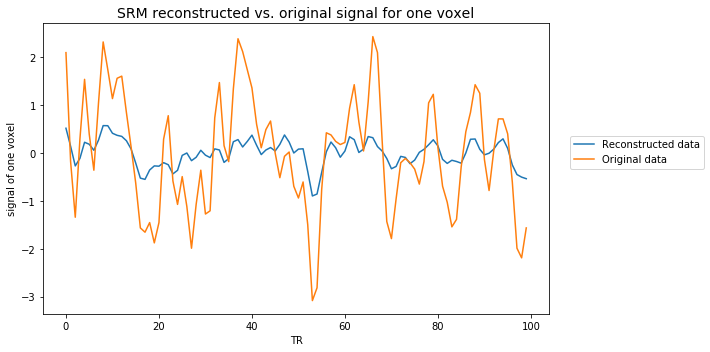

In [20]:
w0 = srm.w_[0]  # Weights for subject 1
signal_srm0 = w0.dot(shared_test[0])  # Reconstructed signal for subject 1

plt.figure(figsize=(10,5))
plt.title('SRM reconstructed vs. original signal for one voxel', fontsize=14)
plt.plot(signal_srm0[100,:100])
plt.plot(test_data[0][100,:100])
plt.xlabel('TR')
plt.ylabel('signal of one voxel')
plt.legend(('Reconstructed data', 'Original data'), loc=(1.04,0.5))
plt.tight_layout()

There is an evident reduction in variance although the trends are maintained. 

Do the reconstruction on all individual participants and organize it for ISC.

In [21]:
signal_srm = np.zeros((test_data[0].shape[0], test_data[0].shape[1], len(test_data)))
for ppt in range(len(test_data)):
    w = srm.w_[ppt]
    signal_srm[:, :, ppt] = w.dot(shared_test[ppt])
signal_srm_for_isc=np.transpose(signal_srm,[1,0,2]) # TRs x Voxels x Subjects for ISC.
corr_reconstructed = isc(signal_srm_for_isc, summary_statistic='mean')
corr_reconstructed = np.nan_to_num(corr_reconstructed)

Dependent samples t test between raw and SRM transformed data: -32.33216626202398 p: 1.6064974902260386e-157


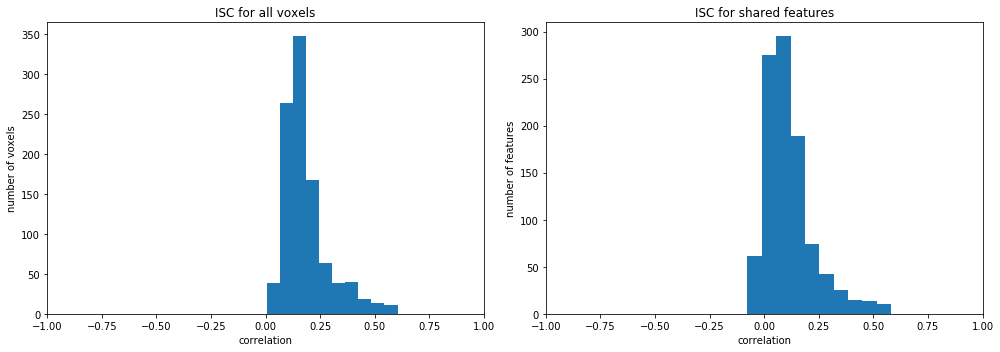

In [22]:
# Plot the figure
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.title('ISC for all voxels')
plt.hist(corr_raw);
plt.xlabel('correlation')
plt.ylabel('number of voxels')
plt.xlim([-1, 1]);

plt.subplot(1, 2, 2)
plt.title('ISC for shared features')
plt.hist(corr_reconstructed);
plt.xlabel('correlation')
plt.ylabel('number of features')
plt.xlim([-1, 1]);

plt.tight_layout()

tstat = stats.ttest_1samp(np.arctanh(corr_reconstructed) - np.arctanh(corr_raw), 0)
print('Dependent samples t test between raw and SRM transformed data:', tstat.statistic, 'p:', tstat.pvalue)


Like we saw before, SRM is good at making participants similar participants to one another. In this case, `signal_srm` is a denoised version of the original data.

## 5. Time-segment matching<a id="time_seg"></a>
One of the tests that has been used to quantify the benefits of SRM is *time-segment matching*. This test involves taking an isolated, unknown segment of fMRI data from a held-out subject and trying to determine *when in the movie* the segment occurred, by comparing the segment to the whole fMRI time series acquired from other subjects. If you have a 30s "mystery" segment of data from a held-out subject, you could compare it to all 30s segments of group data from the whole movie and see which one has the highest neural similarity. For example, if the mystery segment matches best to the segment taken from 1:00 to 1:30 of the movie and that is actual time period during which the mystery segment of fMRI data was acquired, the match would be correct.  

The intuition behind time-segment matching is that, if the fMRI time series are well-aligned across participants and different parts of the movie have unique fMRI signatures, it should be possible to identify the mystery segment by comparing that segment to properly-timestamped fMRI time series from other participants. One might expect SRM to boost time-segment-matching accuracy, compared to anatomically aligned voxel space, by increasing the consistency of neural patterns across subjects.

The following sequence of steps is used to perform time-segment matching:

> - Create a sliding window of size `win_size`.
> - Break time series into `nseg` overlapping windows. 
> - Extract data for each of these segments.
> - One subject is taken out for leave-one-subject-out testing. Note the input data contain all subjects. The removal of one subject from a list for cross-validation is similar to what we covered in previous notebooks (e.g., FCMA).
> - A correlation is computed between the segments in the held-out subject and the segments from the average of the other subjects (similar ISC). The `compute_correlation` function in BrainIAK is used to calculate this.  
> - For each segment in the held-out subject, the segment from the average of others with the maximum correlation value is found.  
> - If the maximum correlation corresponds to the same time period in the test and training data, we score that as an accurate classification.  
> - The final accuracy of the classifier is returned for all subjects.  

In [28]:
# Take in a list of participants of voxel by TR data. Also specify how big the time segment is to be matched
def time_segment_matching(data, win_size=10): 
    nsubjs = len(data)
    (ndim, nsample) = data[0].shape
    accu = np.zeros(shape=nsubjs)
    nseg = nsample - win_size 
    
    # mysseg prediction
    trn_data = np.zeros((ndim*win_size, nseg),order='f')
    
    # the training data also include the test data, but will be subtracted when calculating A
    for m in range(nsubjs):
        for w in range(win_size):
            trn_data[w*ndim:(w+1)*ndim,:] += data[m][:,w:(w+nseg)]
    for tst_subj in range(nsubjs):
        tst_data = np.zeros((ndim*win_size, nseg),order='f')
        for w in range(win_size):
            tst_data[w*ndim:(w+1)*ndim,:] = data[tst_subj][:,w:(w+nseg)]

        A =  np.nan_to_num(stats.zscore((trn_data - tst_data),axis=0, ddof=1))
        B =  np.nan_to_num(stats.zscore(tst_data,axis=0, ddof=1))

        # compute correlation matrix
        corr_mtx = compute_correlation(B.T,A.T)

        # The correlation classifier.
        for i in range(nseg):
            for j in range(nseg):
                # exclude segments overlapping with the testing segment
                if abs(i-j)<win_size and i != j :
                    corr_mtx[i,j] = -np.inf
        max_idx =  np.argmax(corr_mtx, axis=1)
        accu[tst_subj] = sum(max_idx == range(nseg)) / nseg

        # Print accuracy
        print("Accuracy for subj %d is: %0.4f" % (tst_subj, accu[tst_subj] ))
        
    print("The average accuracy among all subjects is {0:f} +/- {1:f}".format(np.mean(accu), np.std(accu)))
    return accu, np.mean(accu), np.std(accu)


First we are going to run time-segment matching on the training data in voxel space, without using any SRM.

In [29]:
accu_train_r, mean1, std1 = time_segment_matching(train_data, win_size=10)

Accuracy for subj 0 is: 0.1237
Accuracy for subj 1 is: 0.1366
Accuracy for subj 2 is: 0.0449
Accuracy for subj 3 is: 0.1842
Accuracy for subj 4 is: 0.1595
Accuracy for subj 5 is: 0.0871
Accuracy for subj 6 is: 0.1485
Accuracy for subj 7 is: 0.1586
Accuracy for subj 8 is: 0.1008
Accuracy for subj 9 is: 0.2007
The average accuracy among all subjects is 0.134464 +/- 0.044484


Run for voxel test data 

In [30]:
accu_test_r, mean2, std2 = time_segment_matching(test_data, win_size=10)

Accuracy for subj 0 is: 0.1668
Accuracy for subj 1 is: 0.1182
Accuracy for subj 2 is: 0.0834
Accuracy for subj 3 is: 0.1769
Accuracy for subj 4 is: 0.1531
Accuracy for subj 5 is: 0.1201
Accuracy for subj 6 is: 0.0999
Accuracy for subj 7 is: 0.1430
Accuracy for subj 8 is: 0.1256
Accuracy for subj 9 is: 0.1714
The average accuracy among all subjects is 0.135839 +/- 0.029937


The results show that trying to determine a time segment from raw data is quite difficult. Note that 13% is not bad because chance accuracy is less than 1% (1/number of segments = 1/1082 = 0.09%), but let's see if we can do better with SRM. 

In [31]:
accu_train, mean3, std3 = time_segment_matching(srm.transform(train_data), win_size=10)
accu_test, mean4, std4 = time_segment_matching(srm.transform(test_data), win_size=10)


Accuracy for subj 0 is: 0.9844
Accuracy for subj 1 is: 0.9973
Accuracy for subj 2 is: 0.9184
Accuracy for subj 3 is: 0.9991
Accuracy for subj 4 is: 0.9991
Accuracy for subj 5 is: 0.9798
Accuracy for subj 6 is: 1.0000
Accuracy for subj 7 is: 0.9963
Accuracy for subj 8 is: 1.0000
Accuracy for subj 9 is: 1.0000
The average accuracy among all subjects is 0.987443 +/- 0.023979
Accuracy for subj 0 is: 0.9019
Accuracy for subj 1 is: 0.7269
Accuracy for subj 2 is: 0.7544
Accuracy for subj 3 is: 0.9478
Accuracy for subj 4 is: 0.8598
Accuracy for subj 5 is: 0.8341
Accuracy for subj 6 is: 0.8973
Accuracy for subj 7 is: 0.7993
Accuracy for subj 8 is: 0.8561
Accuracy for subj 9 is: 0.9597
The average accuracy among all subjects is 0.853712 +/- 0.073250


SRM does significantly better in accurately predicting the segment of the movie being watched from neural correlates. 

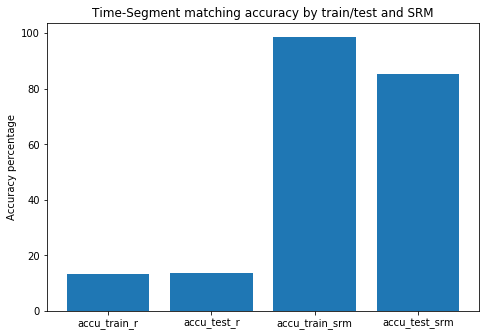

In [45]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

conds = ['accu_train_r', 'accu_test_r', 'accu_train_srm', 'accu_test_srm']
means = [mean1, mean2, mean3, mean4]
new_means = [i * 100 for i in means]
stds = [std1, std2, std3, std4]
ax.set_ylabel('Accuracy percentage')
ax.set_title('Time-Segment matching accuracy by train/test and SRM')
ax.bar(conds,new_means)
plt.show()

Explore how the number of time points used for training the SRM affect time-segment matching performance? Currently we are using half for training and half for testing but you can choose any proportion. Fill in the missing code to vary the proportion of time-points used for SRM training from 0.05, 0.1, 0.2, 0.4, and 0.6 and see how this changes time-segment matching accuracy for the held-out participant. 

In [51]:
# Preset some variables

accu = [] # Preset where you will store the average accuracy for each training set size
se = [] # Preset where you will store the standard error for each training set size

# Set up a loop to iterate through the different proportions of training data
prop_steps = [0.05, 0.1, 0.2, 0.4, 0.6]
for prop_split in prop_steps:

    # Figure out how many TRs there for this proportion
    num_split = int(nTR * prop_split)
    print(num_split)
    # Get the training and test data and Zscore both of them
    train_data = []
    test_data = []
    for sub in range(num_subs):
        train_data.append(movie_data[:, :num_split, sub])
        test_data.append(movie_data[:, -(num_split):, sub])  
    for sub in range(num_subs):    
        # Do it for training data
        train_data[sub] = stats.zscore(train_data[sub], axis=1, ddof=1)
        train_data[sub] = np.nan_to_num(train_data[sub])
    
        # Do it for test data
        test_data[sub] = stats.zscore(test_data[sub], axis=1, ddof=1)
        test_data[sub] = np.nan_to_num(test_data[sub])
    
    # Create the SRM object
    srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=features)

    # Fit the SRM data
    srm.fit(train_data)

    # Transform the test data into the shared space using the individual weight matrices
    shared_test = srm.transform(test_data)
    
    # Zscore the transformed test data
    for subject in range(num_subs):
        shared_test[subject] = stats.zscore(shared_train[subject], axis=1, ddof=1)

    # Run time segment matching
    accu_test, mean, std = time_segment_matching(shared_test, win_size = 10)
    
    # Append results of time segment matching to the list
    accu.append(mean)
    se.append(std)


110
Accuracy for subj 0 is: 1.0000
Accuracy for subj 1 is: 0.9982
Accuracy for subj 2 is: 0.9982
Accuracy for subj 3 is: 1.0000
Accuracy for subj 4 is: 1.0000
Accuracy for subj 5 is: 1.0000
Accuracy for subj 6 is: 1.0000
Accuracy for subj 7 is: 1.0000
Accuracy for subj 8 is: 1.0000
Accuracy for subj 9 is: 1.0000
The average accuracy among all subjects is 0.999633 +/- 0.000733
220
Accuracy for subj 0 is: 1.0000
Accuracy for subj 1 is: 0.9982
Accuracy for subj 2 is: 0.9982
Accuracy for subj 3 is: 1.0000
Accuracy for subj 4 is: 1.0000
Accuracy for subj 5 is: 1.0000
Accuracy for subj 6 is: 1.0000
Accuracy for subj 7 is: 1.0000
Accuracy for subj 8 is: 1.0000
Accuracy for subj 9 is: 1.0000
The average accuracy among all subjects is 0.999633 +/- 0.000733
440
Accuracy for subj 0 is: 1.0000
Accuracy for subj 1 is: 0.9982
Accuracy for subj 2 is: 0.9982
Accuracy for subj 3 is: 1.0000
Accuracy for subj 4 is: 1.0000
Accuracy for subj 5 is: 1.0000
Accuracy for subj 6 is: 1.0000
Accuracy for subj 7 i

**Accuracy is high from the start but increases with amount of training data. SRM is highly effective with this dataset and sufficient training data.**

## Contributions <a id="contributions"></a>
M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook 4/4/18  
C. Chen provided initial code  
H. Zhang major edits, added more exercises, added image class prediction section, filled in solutions, processed raider dataset, novel contribution ideas.  
M. Kumar edited sections and added details to the time-segment matching function.  
K.A. Norman provided suggestions on the overall content and made edits to this notebook.  
C. Ellis incorporated edits from cmhn-s19.  